In [1]:
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data = pd.read_csv('../results/results_summary.csv')

In [3]:
measures = ['Percent Abandoned', 'Ambulance Utilisation', 'RRV Utilisation', 'Mean Response Time', 'Percent Response < 8', 'Percent Response < 15', 'Percent Response < 60', 'Percent Response within Target']

In [4]:
data_mean = pd.DataFrame(data.groupby(['Demand Level', 'Scenario', 'Resource Level'])[measures].mean()).reset_index()
data_max = pd.DataFrame(data.groupby(['Demand Level', 'Scenario', 'Resource Level'])[measures].max()).reset_index()
data_min = pd.DataFrame(data.groupby(['Demand Level', 'Scenario', 'Resource Level'])[measures].min()).reset_index()

In [5]:
objectives = []
for demand in [13, 19, 34, 45]:
    for scenario in ['noRRV', 'withRRV']:
        objectives += pd.read_csv(f'../../../allocations/demand_{demand}_{scenario}_out.csv', index_col=0, names=range(23))[7].values.tolist()

In [6]:
data_mean['Objective'] = objectives

In [7]:
scenario_names = {
    'noRRV': 'Single Vehicle',
    'withRRV': 'Multiple Vehicles'
}
scenario_names_file = {
    'noRRV': 'single',
    'withRRV': 'multiple'
}

In [8]:
def plot_scenario_year(scenario):
    demand_levels = [13, 19, 34, 45]
    colours = ['forestgreen', 'gold', 'darkorange', 'red']
    mean_datas = {
        d: data_mean[(data_mean['Demand Level'] == d) & (data_mean['Scenario'] == scenario)][measures + ['Objective'] + ['Resource Level']].set_index('Resource Level')
        for d in demand_levels
    }
    max_datas = {
        d: data_max[(data_max['Demand Level'] == d) & (data_max['Scenario'] == scenario)][measures + ['Resource Level']].set_index('Resource Level')
        for d in demand_levels
    }
    min_datas = {
        d: data_min[(data_min['Demand Level'] == d) & (data_min['Scenario'] == scenario)][measures + ['Resource Level']].set_index('Resource Level')
        for d in demand_levels
    }
    
    ls = {}
    fig, axarr = plt.subplots(3, 2, figsize=(12, 16))
    for d, c in zip(demand_levels, colours):
        plot_ambulance_utilisations(ax=axarr[0, 0], demand_level=d, colour=c, mean_datas=mean_datas, max_datas=max_datas, min_datas=min_datas)
        plot_rrv_utilisations(ax=axarr[0, 1], demand_level=d, colour=c, mean_datas=mean_datas, max_datas=max_datas, min_datas=min_datas)
        plot_percent_abandoned(ax=axarr[1, 0], demand_level=d, colour=c, mean_datas=mean_datas, max_datas=max_datas, min_datas=min_datas)
        plot_mean_response_times(ax=axarr[1, 1], demand_level=d, colour=c, mean_datas=mean_datas, max_datas=max_datas, min_datas=min_datas)
        plot_percent_within_target(ax=axarr[2, 0], demand_level=d, colour=c, mean_datas=mean_datas, max_datas=max_datas, min_datas=min_datas)
        plot_objective(ax=axarr[2, 1], demand_level=d, colour=c, mean_datas=mean_datas)
        ls[d] = axarr[0, 1].plot([], [], c=c, label=f"Demand {d}%")
    axarr[0, 1].legend(fontsize=16, frameon=True)
    fig.suptitle(f'Scenario: {scenario_names[scenario]}', fontsize=24)
    plt.tight_layout()
    fig.savefig(f'../plots/plot_{scenario_names_file[scenario]}_allplots.pdf')
    return fig

In [9]:
def plot_ambulance_utilisations(ax, demand_level, colour, mean_datas, max_datas, min_datas):
    ax.fill_between(
        range(60, 99),
        min_datas[demand_level]['Ambulance Utilisation'] * 100,
        max_datas[demand_level]['Ambulance Utilisation'] * 100,
        alpha=0.3,
        color=colour
    )
    ax.plot(mean_datas[demand_level]['Ambulance Utilisation'] * 100, color=colour)
    ax.set_ylim(0, 100)
    ax.set_ylabel('Ambulance Utilisation (%)', fontsize=16)
    ax.set_xlabel('Resource Level', fontsize=16)
    ax.set_xlim(60, 98)
    ax.set_xticks(range(60, 99, 2))
    ax.tick_params(axis='y', which='major', labelsize=14)

In [10]:
def plot_rrv_utilisations(ax, demand_level, colour, mean_datas, max_datas, min_datas):
    ax.fill_between(
        range(60, 99),
        min_datas[demand_level]['RRV Utilisation'] * 100,
        max_datas[demand_level]['RRV Utilisation'] * 100,
        alpha=0.3,
        color=colour
    )
    ax.plot(mean_datas[demand_level]['RRV Utilisation'] * 100, color=colour)
    ax.set_ylim(0, 100)
    ax.set_ylabel('RRV Utilisation (%)', fontsize=16)
    ax.set_xlabel('Resource Level', fontsize=16)
    ax.set_xlim(60, 98)
    ax.set_xticks(range(60, 99, 2))
    ax.tick_params(axis='y', which='major', labelsize=14)

In [11]:
def plot_percent_abandoned(ax, demand_level, colour, mean_datas, max_datas, min_datas):
    ax.fill_between(
        range(60, 99),
        min_datas[demand_level]['Percent Abandoned'] * 100,
        max_datas[demand_level]['Percent Abandoned'] * 100,
        alpha=0.3,
        color=colour
    )
    ax.plot(mean_datas[demand_level]['Percent Abandoned'] * 100, color=colour)
    ax.set_ylim(0, 100)
    ax.set_ylabel('Percent Abandoned', fontsize=16)
    ax.set_xlabel('Resource Level', fontsize=16)
    ax.set_xlim(60, 98)
    ax.set_xticks(range(60, 99, 2))
    ax.tick_params(axis='y', which='major', labelsize=14)

In [12]:
def plot_mean_response_times(ax, demand_level, colour, mean_datas, max_datas, min_datas):
    ax.fill_between(
        range(60, 99),
        min_datas[demand_level]['Mean Response Time'] * (24 * 60),
        max_datas[demand_level]['Mean Response Time'] * (24 * 60),
        alpha=0.3,
        color=colour
    )
    ax.plot(mean_datas[demand_level]['Mean Response Time'] * (24 * 60), color=colour)
    ax.set_ylabel('Mean Response Time (mins)', fontsize=16)
    ax.set_xlabel('Resource Level', fontsize=16)
    ax.set_xlim(60, 98)
    ax.set_xticks(range(60, 99, 2))
    ax.tick_params(axis='y', which='major', labelsize=14)

In [13]:
def plot_percent_within_target(ax, demand_level, colour, mean_datas, max_datas, min_datas):
    ax.fill_between(
        range(60, 99),
        min_datas[demand_level]['Percent Response within Target'] * 100,
        max_datas[demand_level]['Percent Response within Target'] * 100,
        alpha=0.3,
        color=colour
    )
    ax.plot(mean_datas[demand_level]['Percent Response within Target'] * 100, color=colour)
    ax.set_ylim(0, 100)
    ax.set_ylabel('Percent Response within Target', fontsize=16)
    ax.set_xlabel('Resource Level', fontsize=16)
    ax.set_xlim(60, 98)
    ax.set_xticks(range(60, 99, 2))
    ax.tick_params(axis='y', which='major', labelsize=14)

In [14]:
def plot_percent_less_than(ax, demand_level, colour, mean_datas, max_datas, min_datas, t):
    ax.fill_between(
        range(60, 99),
        min_datas[demand_level][f'Percent Response < {t}'] * 100,
        max_datas[demand_level][f'Percent Response < {t}'] * 100,
        alpha=0.3,
        color=colour
    )
    ax.plot(mean_datas[demand_level][f'Percent Response < {t}'] * 100, color=colour)
    ax.set_ylabel(f'Percent Response < {t}', fontsize=16)
    ax.set_xlabel('Resource Level', fontsize=16)
    ax.set_xlim(60, 98)
    ax.set_xticks(range(60, 99, 2))
    ax.tick_params(axis='y', which='major', labelsize=14)

In [15]:
def plot_objective(ax, demand_level, colour, mean_datas):
    ax.plot(mean_datas[demand_level]['Objective'], color=colour)
    ax.set_ylabel(f'MESLMHPHF Objective Function', fontsize=16)
    ax.set_xlabel('Resource Level', fontsize=16)
    ax.set_xlim(60, 98)
    ax.set_xticks(range(60, 99, 2))
    ax.tick_params(axis='y', which='major', labelsize=14)

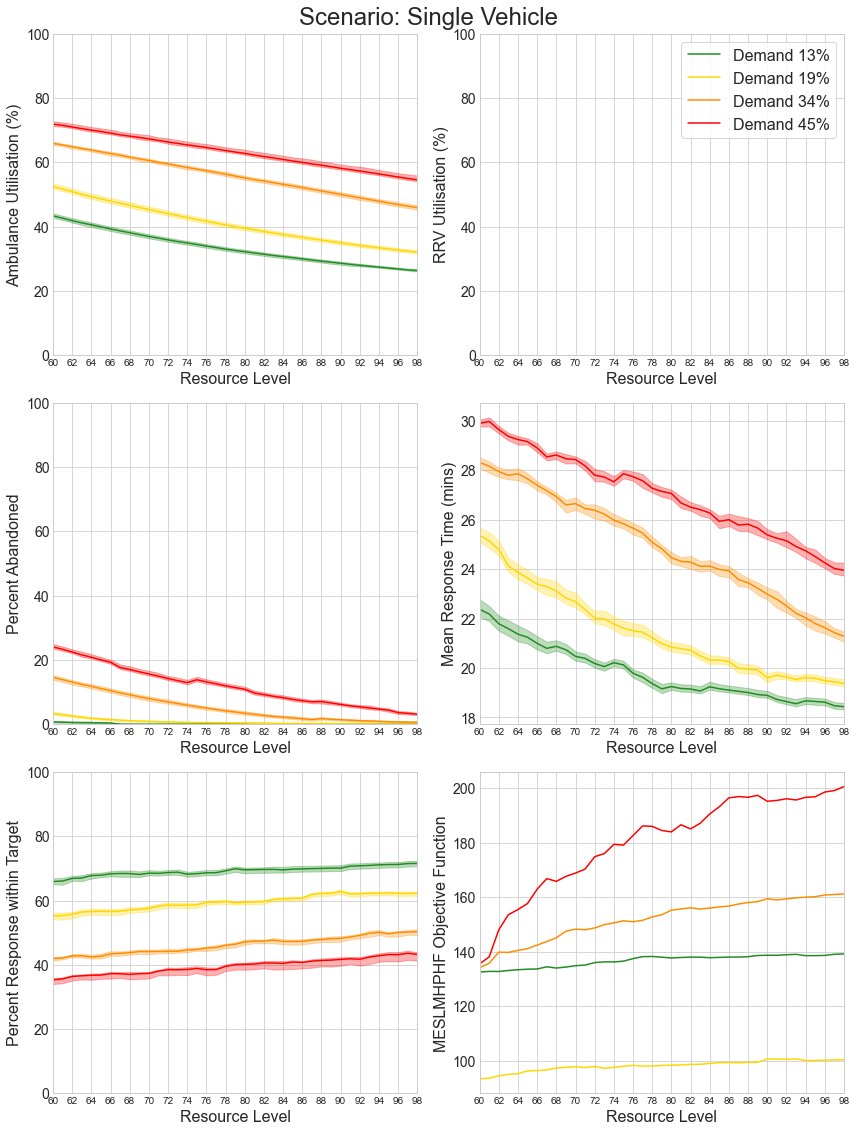

In [16]:
fig = plot_scenario_year('noRRV');

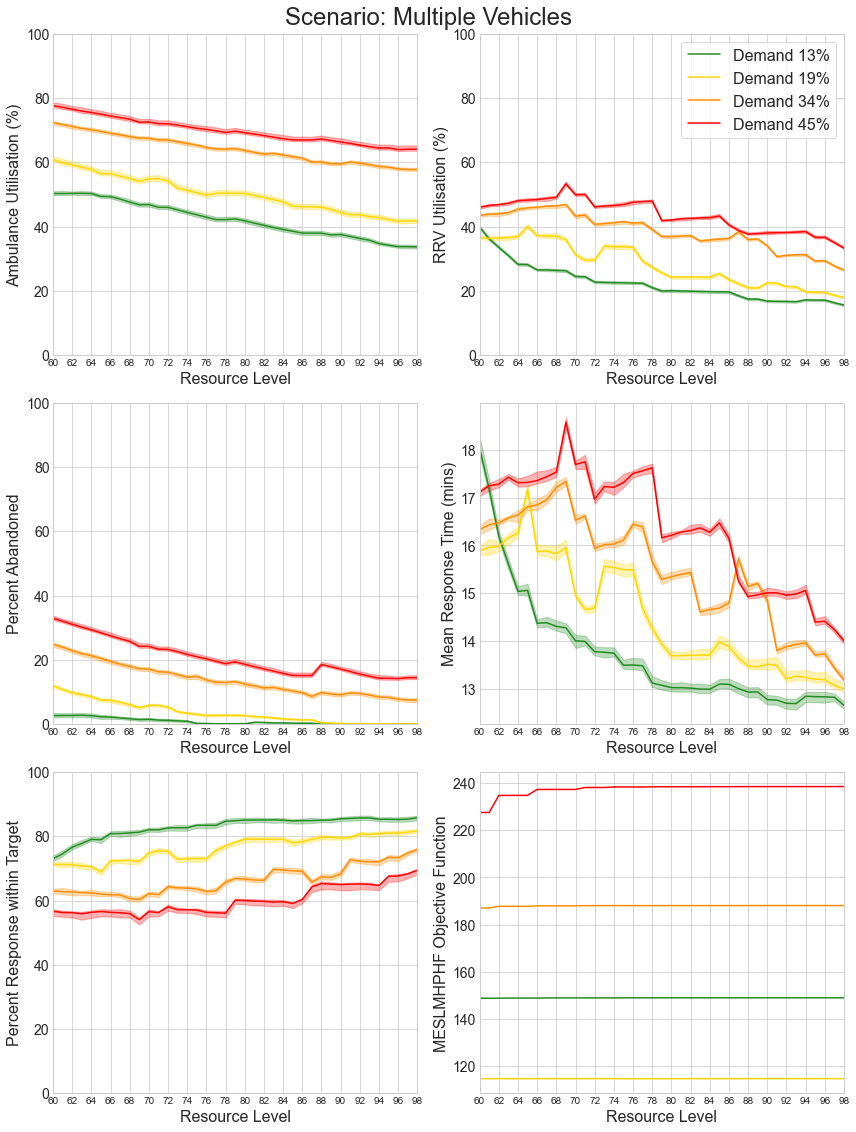

In [17]:
fig = plot_scenario_year('withRRV')

In [18]:
def plot_individual(measure, scenario):
    demand_levels = [13, 19, 34, 45]
    colours = ['forestgreen', 'gold', 'darkorange', 'red']
    mean_datas = {
        d: data_mean[(data_mean['Demand Level'] == d) & (data_mean['Scenario'] == scenario)][measures + ['Objective'] + ['Resource Level']].set_index('Resource Level')
        for d in demand_levels
    }
    max_datas = {
        d: data_max[(data_max['Demand Level'] == d) & (data_max['Scenario'] == scenario)][measures + ['Resource Level']].set_index('Resource Level')
        for d in demand_levels
    }
    min_datas = {
        d: data_min[(data_min['Demand Level'] == d) & (data_min['Scenario'] == scenario)][measures + ['Resource Level']].set_index('Resource Level')
        for d in demand_levels
    }
    
    ls = {}
    fig, ax = plt.subplots(1, figsize=(9, 7))
    for d, c in zip(demand_levels, colours):
        if measure == "Ambulance Utilisation":
            plot_ambulance_utilisations(ax=ax, demand_level=d, colour=c, mean_datas=mean_datas, max_datas=max_datas, min_datas=min_datas)
        if measure == "RRV Utilisation":
            plot_rrv_utilisations(ax=ax, demand_level=d, colour=c, mean_datas=mean_datas, max_datas=max_datas, min_datas=min_datas)
        if measure == "Percent Abandoned":
            plot_percent_abandoned(ax=ax, demand_level=d, colour=c, mean_datas=mean_datas, max_datas=max_datas, min_datas=min_datas)
        if measure == "Mean Response Time":
            plot_mean_response_times(ax=ax, demand_level=d, colour=c, mean_datas=mean_datas, max_datas=max_datas, min_datas=min_datas)
        if measure == "Percent Response < 8":
            plot_percent_less_than(ax=ax, demand_level=d, colour=c, mean_datas=mean_datas, max_datas=max_datas, min_datas=min_datas, t=8)
        if measure == "Percent Response < 15":
            plot_percent_less_than(ax=ax, demand_level=d, colour=c, mean_datas=mean_datas, max_datas=max_datas, min_datas=min_datas, t=15)
        if measure == "Percent Response < 60":
            plot_percent_less_than(ax=ax, demand_level=d, colour=c, mean_datas=mean_datas, max_datas=max_datas, min_datas=min_datas, t=60)
        if measure == "Percent Response within Target":
            plot_percent_within_target(ax=ax, demand_level=d, colour=c, mean_datas=mean_datas, max_datas=max_datas, min_datas=min_datas)
        if measure == "Objective":
            plot_objective(ax=ax, demand_level=d, colour=c, mean_datas=mean_datas)
        ls[d] = ax.plot([], [], c=c, label=f"{d}%")
    p1, p2, p3, p4 = 0.9, 1.2, 0.95, 0.78
    legend = ax.legend(fontsize=16, ncol=4, frameon=True, bbox_to_anchor=(p1, p2), title='Demand Level')
    legend.get_title().set_fontsize('16')
    if scenario == 'noRRV':
        scenario_name = 'Single Vehicle'
    if scenario == 'withRRV':
        scenario_name = 'Multiple Vehicles'
    fig.suptitle(f'Scenario: {scenario_names[scenario]}', fontsize=24, y=p3)
    plt.subplots_adjust(top=p4)
    fig.savefig(f"../plots/{scenario_names_file[scenario]}_{measure.replace(' ', '')}.pdf")
    return fig

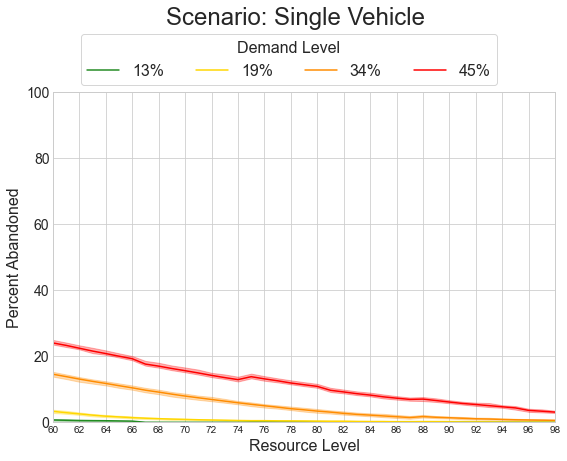

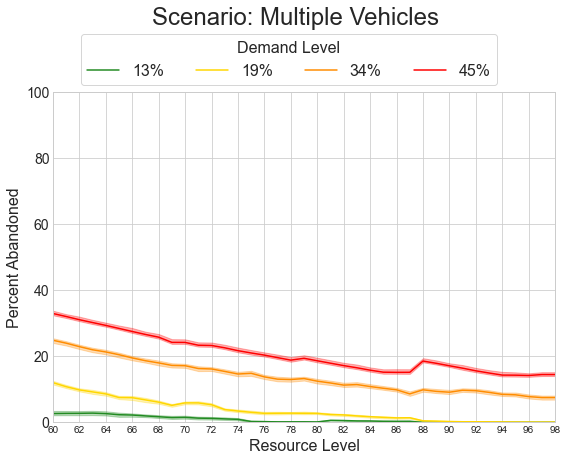

In [19]:
measure = 'Percent Abandoned'
for scenario in ['noRRV', 'withRRV']:
    fig = plot_individual(measure, scenario);

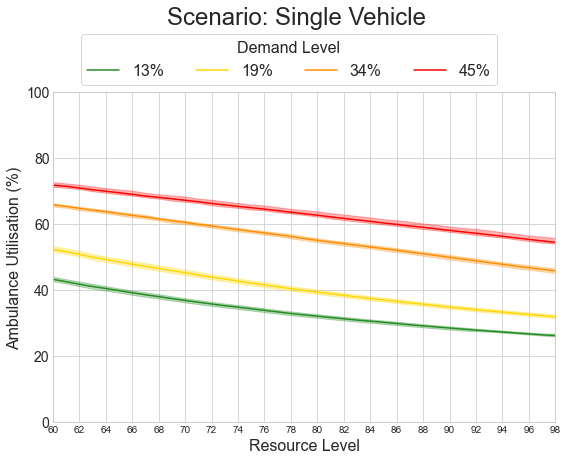

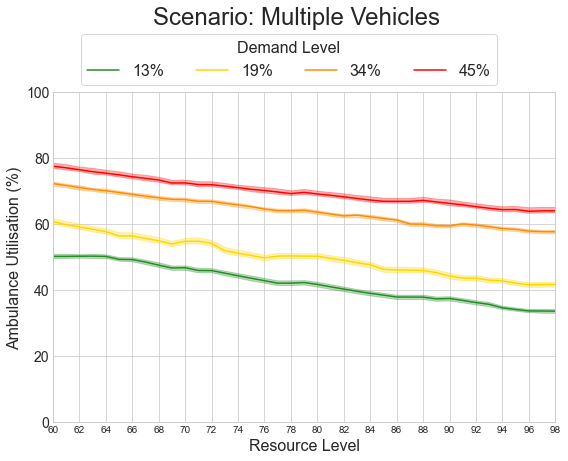

In [20]:
measure = 'Ambulance Utilisation'
for scenario in ['noRRV', 'withRRV']:
    fig = plot_individual(measure, scenario);

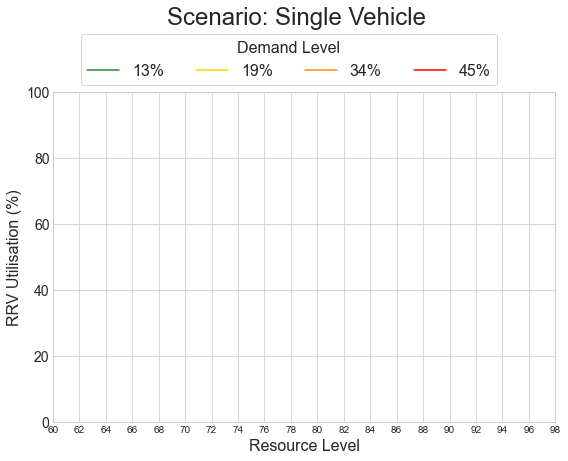

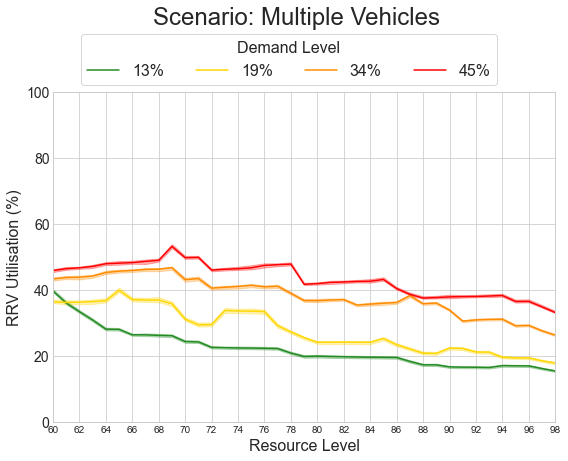

In [21]:
measure = 'RRV Utilisation'
for scenario in ['noRRV', 'withRRV']:
    fig = plot_individual(measure, scenario);

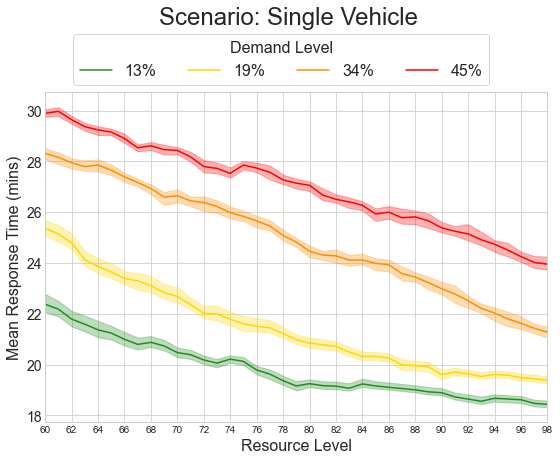

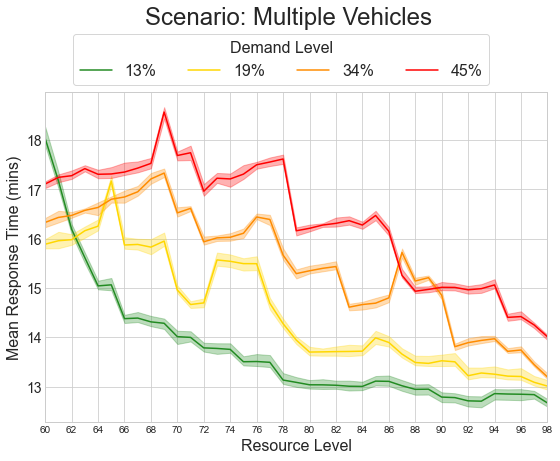

In [22]:
measure = 'Mean Response Time'
for scenario in ['noRRV', 'withRRV']:
    fig = plot_individual(measure, scenario);

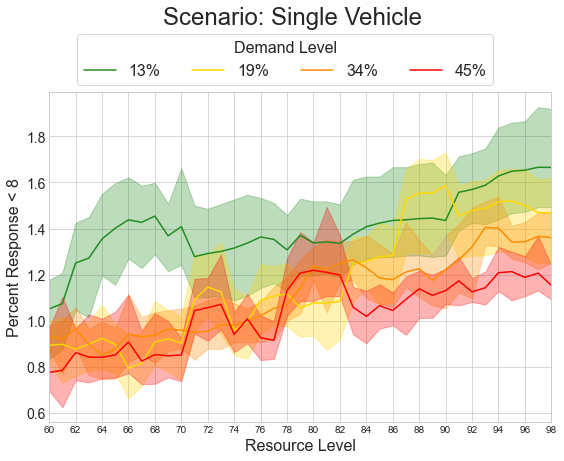

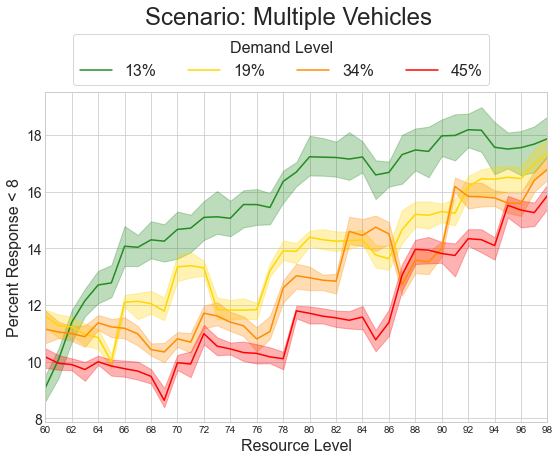

In [23]:
measure = 'Percent Response < 8'
for scenario in ['noRRV', 'withRRV']:
    fig = plot_individual(measure, scenario);

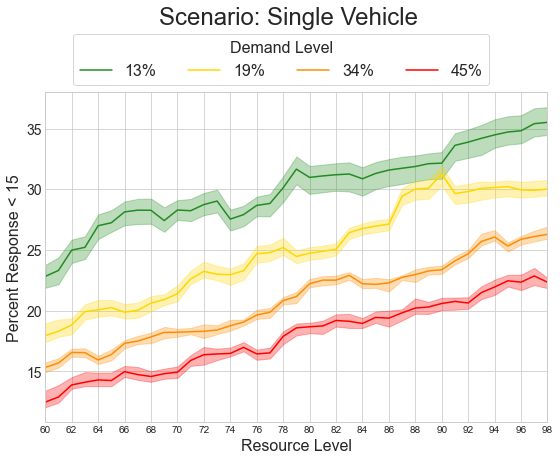

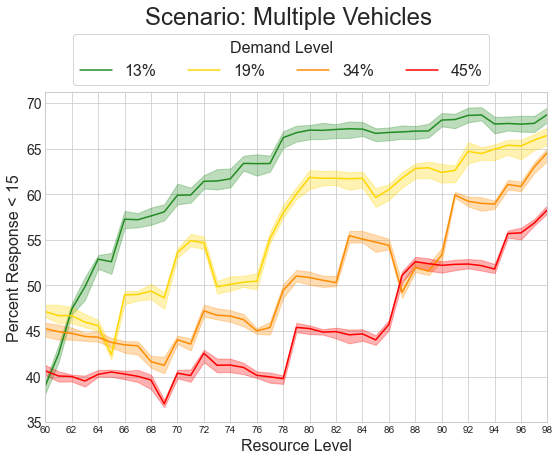

In [24]:
measure = 'Percent Response < 15'
for scenario in ['noRRV', 'withRRV']:
    fig = plot_individual(measure, scenario);

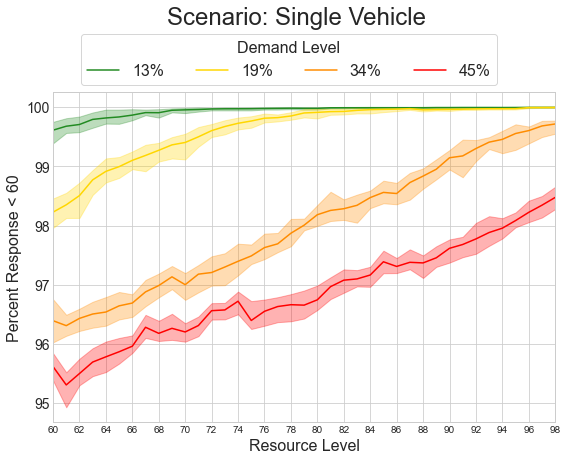

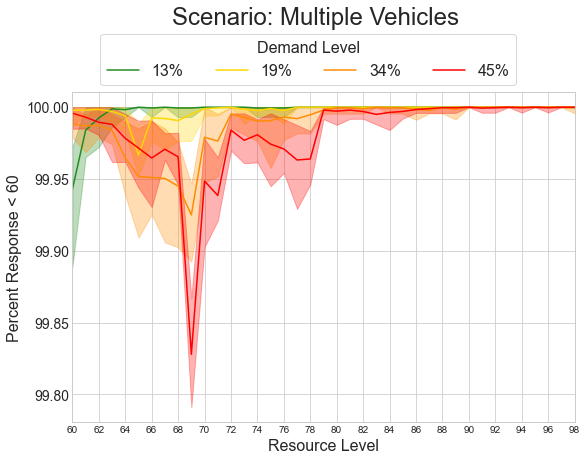

In [25]:
measure = 'Percent Response < 60'
for scenario in ['noRRV', 'withRRV']:
    fig = plot_individual(measure, scenario);

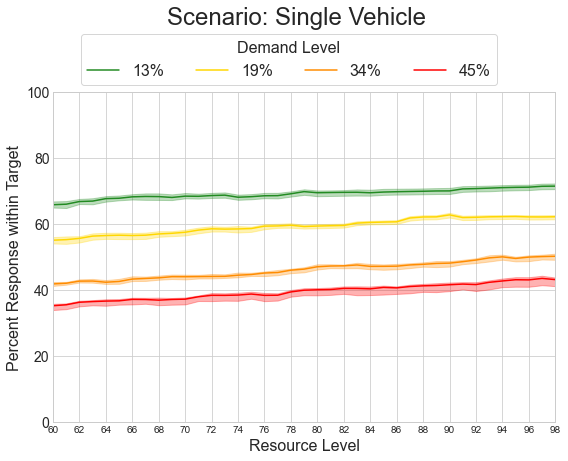

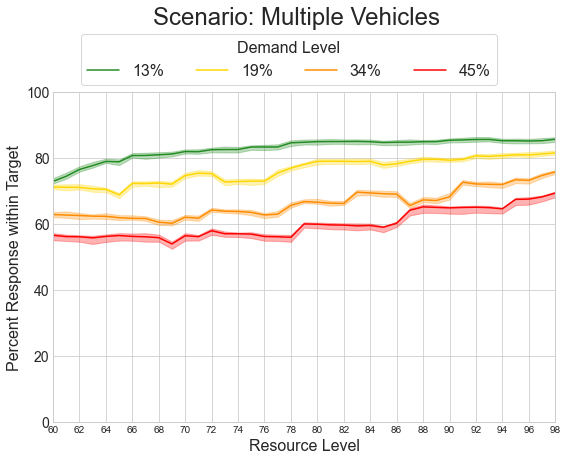

In [26]:
measure = 'Percent Response within Target'
for scenario in ['noRRV', 'withRRV']:
    fig = plot_individual(measure, scenario);

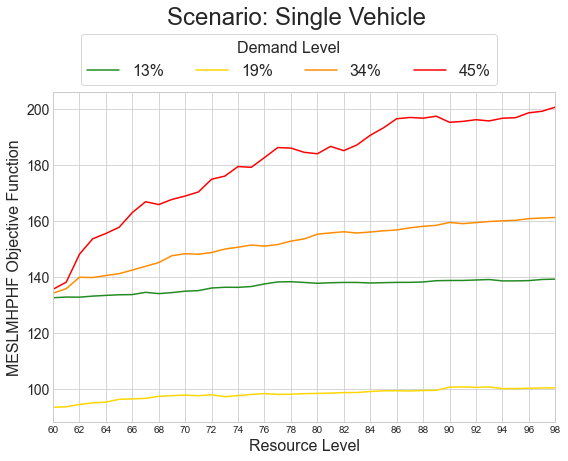

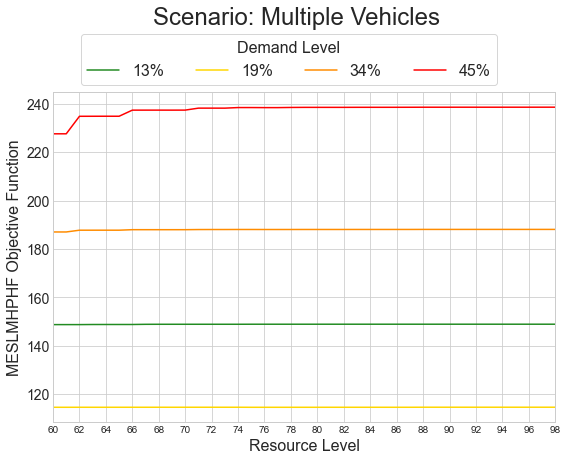

In [27]:
measure = 'Objective'
for scenario in ['noRRV', 'withRRV']:
    fig = plot_individual(measure, scenario);

In [28]:
def plot_individual_13(measure, scenario):
    demand_levels = [13]
    colours = ['forestgreen', 'gold', 'darkorange', 'red']
    mean_datas = {
        d: data_mean[(data_mean['Demand Level'] == d) & (data_mean['Scenario'] == scenario)][measures + ['Objective'] + ['Resource Level']].set_index('Resource Level')
        for d in demand_levels
    }
    max_datas = {
        d: data_max[(data_max['Demand Level'] == d) & (data_max['Scenario'] == scenario)][measures + ['Resource Level']].set_index('Resource Level')
        for d in demand_levels
    }
    min_datas = {
        d: data_min[(data_min['Demand Level'] == d) & (data_min['Scenario'] == scenario)][measures + ['Resource Level']].set_index('Resource Level')
        for d in demand_levels
    }
    
    ls = {}
    fig, ax = plt.subplots(1, figsize=(9, 7))
    for d, c in zip(demand_levels, colours):
        if measure == "Ambulance Utilisation":
            plot_ambulance_utilisations(ax=ax, demand_level=d, colour=c, mean_datas=mean_datas, max_datas=max_datas, min_datas=min_datas)
        if measure == "RRV Utilisation":
            plot_rrv_utilisations(ax=ax, demand_level=d, colour=c, mean_datas=mean_datas, max_datas=max_datas, min_datas=min_datas)
        if measure == "Percent Abandoned":
            plot_percent_abandoned(ax=ax, demand_level=d, colour=c, mean_datas=mean_datas, max_datas=max_datas, min_datas=min_datas)
        if measure == "Mean Response Time":
            plot_mean_response_times(ax=ax, demand_level=d, colour=c, mean_datas=mean_datas, max_datas=max_datas, min_datas=min_datas)
        if measure == "Percent Response < 8":
            plot_percent_less_than(ax=ax, demand_level=d, colour=c, mean_datas=mean_datas, max_datas=max_datas, min_datas=min_datas, t=8)
        if measure == "Percent Response < 15":
            plot_percent_less_than(ax=ax, demand_level=d, colour=c, mean_datas=mean_datas, max_datas=max_datas, min_datas=min_datas, t=15)
        if measure == "Percent Response < 60":
            plot_percent_less_than(ax=ax, demand_level=d, colour=c, mean_datas=mean_datas, max_datas=max_datas, min_datas=min_datas, t=60)
        if measure == "Percent Response within Target":
            plot_percent_within_target(ax=ax, demand_level=d, colour=c, mean_datas=mean_datas, max_datas=max_datas, min_datas=min_datas)
        if measure == "Objective":
            plot_objective(ax=ax, demand_level=d, colour=c, mean_datas=mean_datas)
        ls[d] = ax.plot([], [], c=c, label=f"{d}%")
    p1, p2, p3, p4 = 0.9, 1.2, 0.95, 0.78
#     legend = ax.legend(fontsize=16, ncol=4, frameon=True, bbox_to_anchor=(p1, p2), title='Demand Level')
#     legend.get_title().set_fontsize('16')
    if scenario == 'noRRV':
        scenario_name = 'Single Vehicle'
    if scenario == 'withRRV':
        scenario_name = 'Multiple Vehicles'
    fig.suptitle(f'Scenario: {scenario_names[scenario]}', fontsize=24, y=p3)
#     plt.subplots_adjust(top=p4)
    fig.savefig(f"../plots/{scenario_names_file[scenario]}_{measure.replace(' ', '')}_13only.pdf")
    return fig

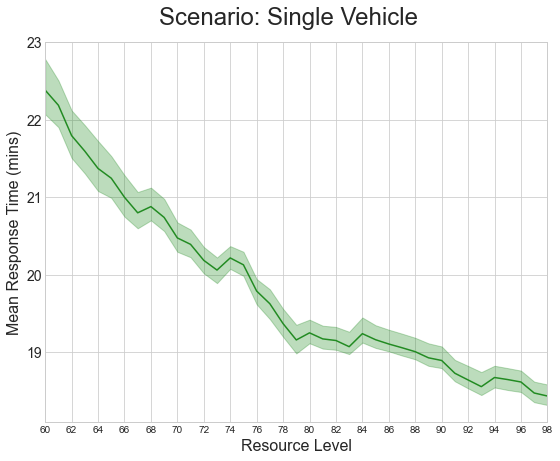

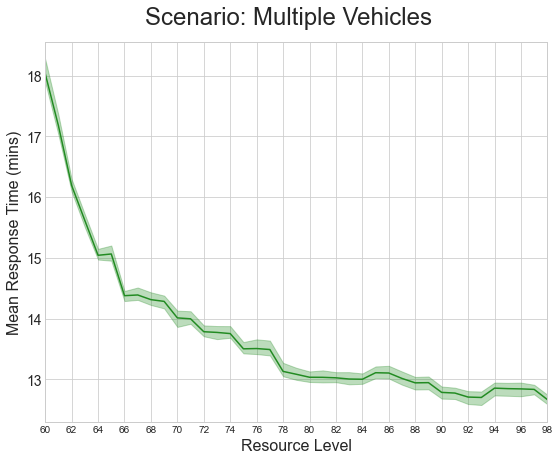

In [29]:
measure = 'Mean Response Time'
for scenario in ['noRRV', 'withRRV']:
    fig = plot_individual_13(measure, scenario);